In [1]:
using CairoMakie, Statistics, LsqFit, GLM, DataFrames

In [2]:
include("io_array.jl")

read_from_csv (generic function with 1 method)

In [3]:
function load_average(filename, num_seeds)
    avg = nothing
    for seed in 1:num_seeds
        data = read_from_file(filename * "_seed=$(seed).txt")
        if avg === nothing
            avg = copy(data)
        else
            avg .+= data
        end
    end

    avg ./= num_seeds

    return avg
end

load_average (generic function with 1 method)

In [4]:
# --- Load data ---

noise_std_list = ["1e-10", "1e-9", "1e-8", "1e-7", "1e-6"]
r2_av_list = []

for noise_std in noise_std_list
    filename = "data//r2_noise_scaling//r2_N=1000_noise=" * string(noise_std) * "_delay=10"
    r2_av = load_average(filename, 25)[:, 1]
    push!(r2_av_list, r2_av)
end
r2_av_list[1]

81-element Vector{Float64}:
 0.00048473964874795676
 0.00048826758128191374
 0.0004957306861293424
 0.0005106631766433467
 0.0005404994444059128
 0.0006022239941821419
 0.000738675937106985
 0.0010692268387858792
 0.0019510998116638988
 0.0044680471335595716
 ⋮
 0.9864207326096421
 0.9820518616964092
 0.9760946697482447
 0.9678627303385946
 0.9564599675573849
 0.9404828045302708
 0.9180764748618877
 0.8875932660982038
 0.8472039119104329

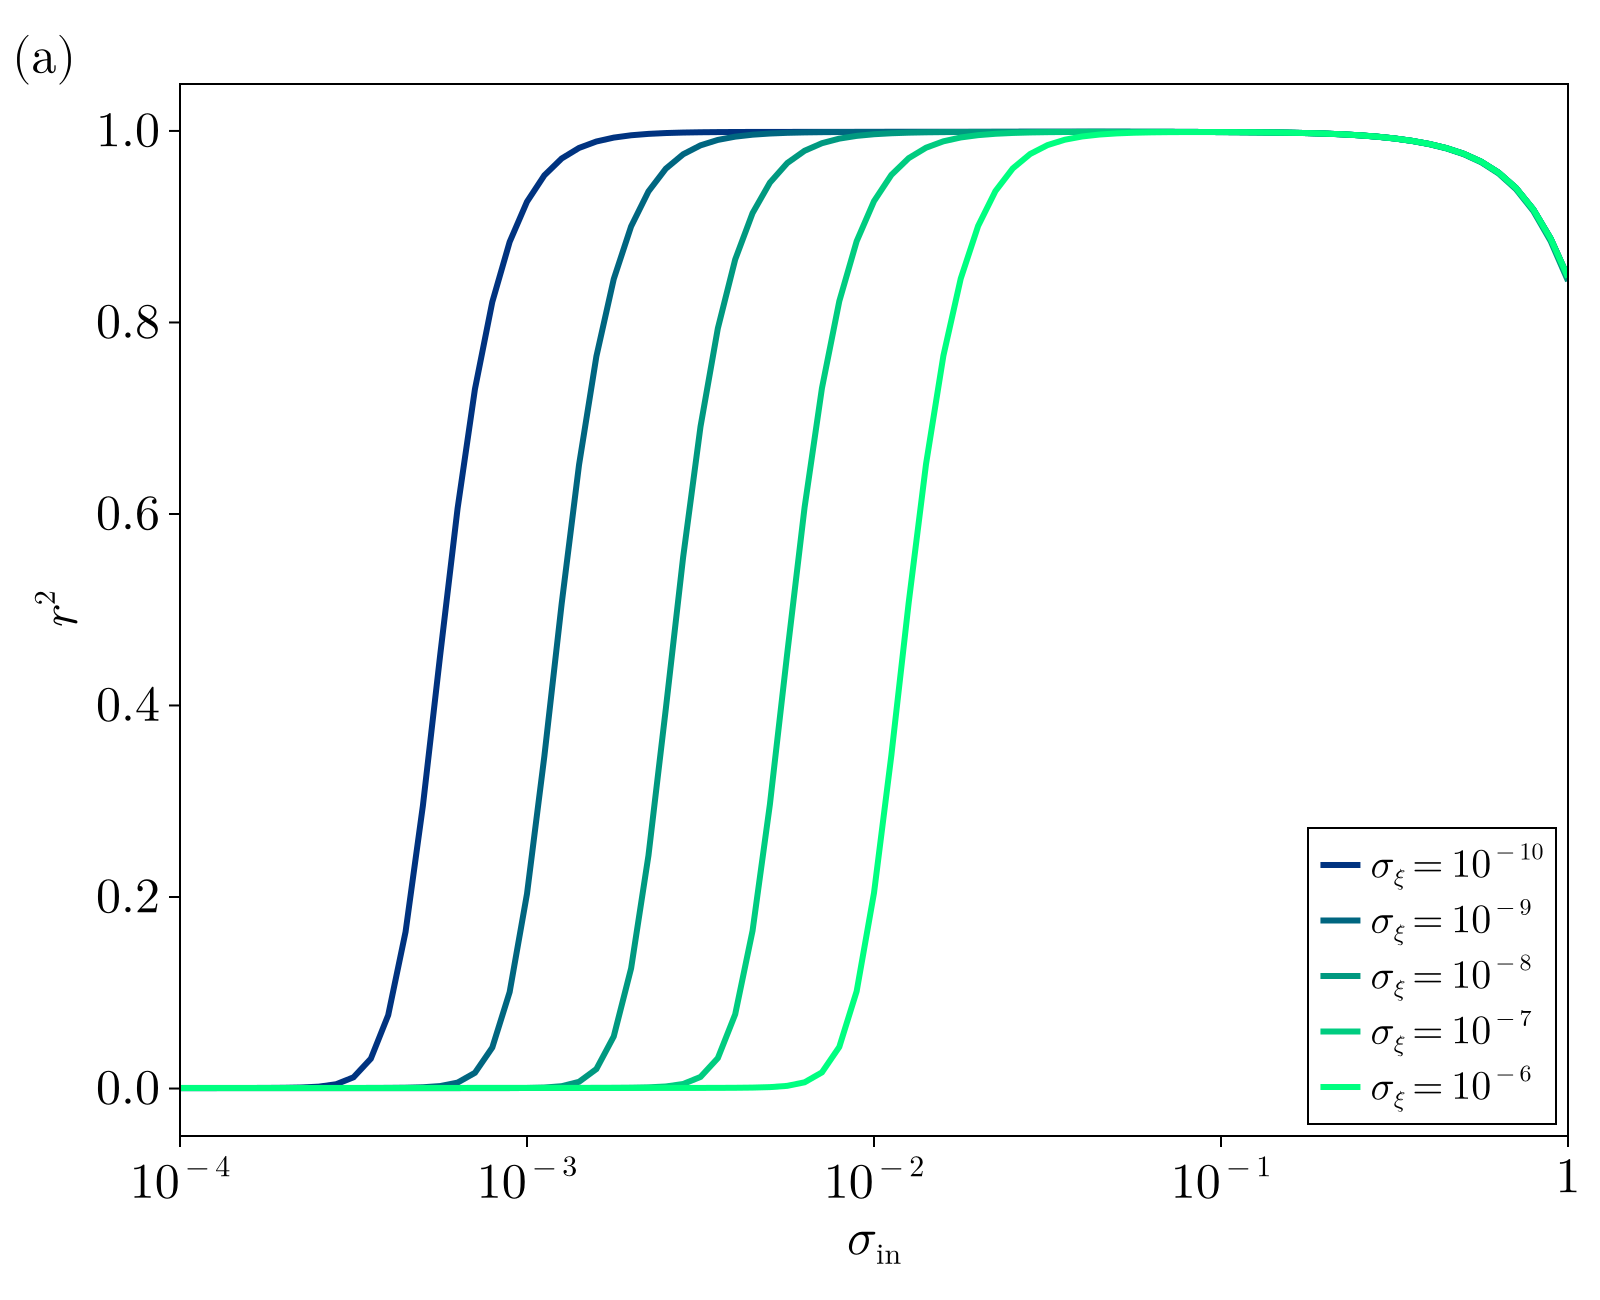

In [5]:
# Grid parameter
input_std_grid = 10.0 .^ (-4:0.05:0.0)

set_theme!(
    fontsize=25,
    Legend=(labelsize=20,),
    Axis=(
        xgridvisible=false,
        ygridvisible=false,
    ),
)

fig = Figure(size=(800, 650))

ax = Axis(fig[1, 1];
    xlabel=L"\sigma_{\mathrm{in}}",
    ylabel=L"r^2",
    xscale=log10,
    xticks=([1e-4, 1e-3, 1e-2, 1e-1, 1], [L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"]),
    yticks=(0.0:0.2:1.0, [L"0.0", L"0.2", L"0.4", L"0.6", L"0.8", L"1.0"]))

lines!(ax, input_std_grid, r2_av_list[1], label=L"\sigma_{\xi} = 10^{-10}", linewidth=3, color=RGBf(0, 0.2, 0.5))
lines!(ax, input_std_grid, r2_av_list[2], label=L"\sigma_{\xi} = 10^{-9}", linewidth=3, color=RGBf(0, 0.4, 0.5))
lines!(ax, input_std_grid, r2_av_list[3], label=L"\sigma_{\xi} = 10^{-8}", linewidth=3, color=RGBf(0, 0.6, 0.5))
lines!(ax, input_std_grid, r2_av_list[4], label=L"\sigma_{\xi} = 10^{-7}", linewidth=3, color=RGBf(0, 0.8, 0.5))
lines!(ax, input_std_grid, r2_av_list[5], label=L"\sigma_{\xi} = 10^{-6}", linewidth=3, color=RGBf(0, 1, 0.5))

xlims!(ax, 1e-4, 1)

axislegend(ax; position=:rb)

Label(fig[1, 1, TopLeft()], L"\mathrm{(a)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

fig

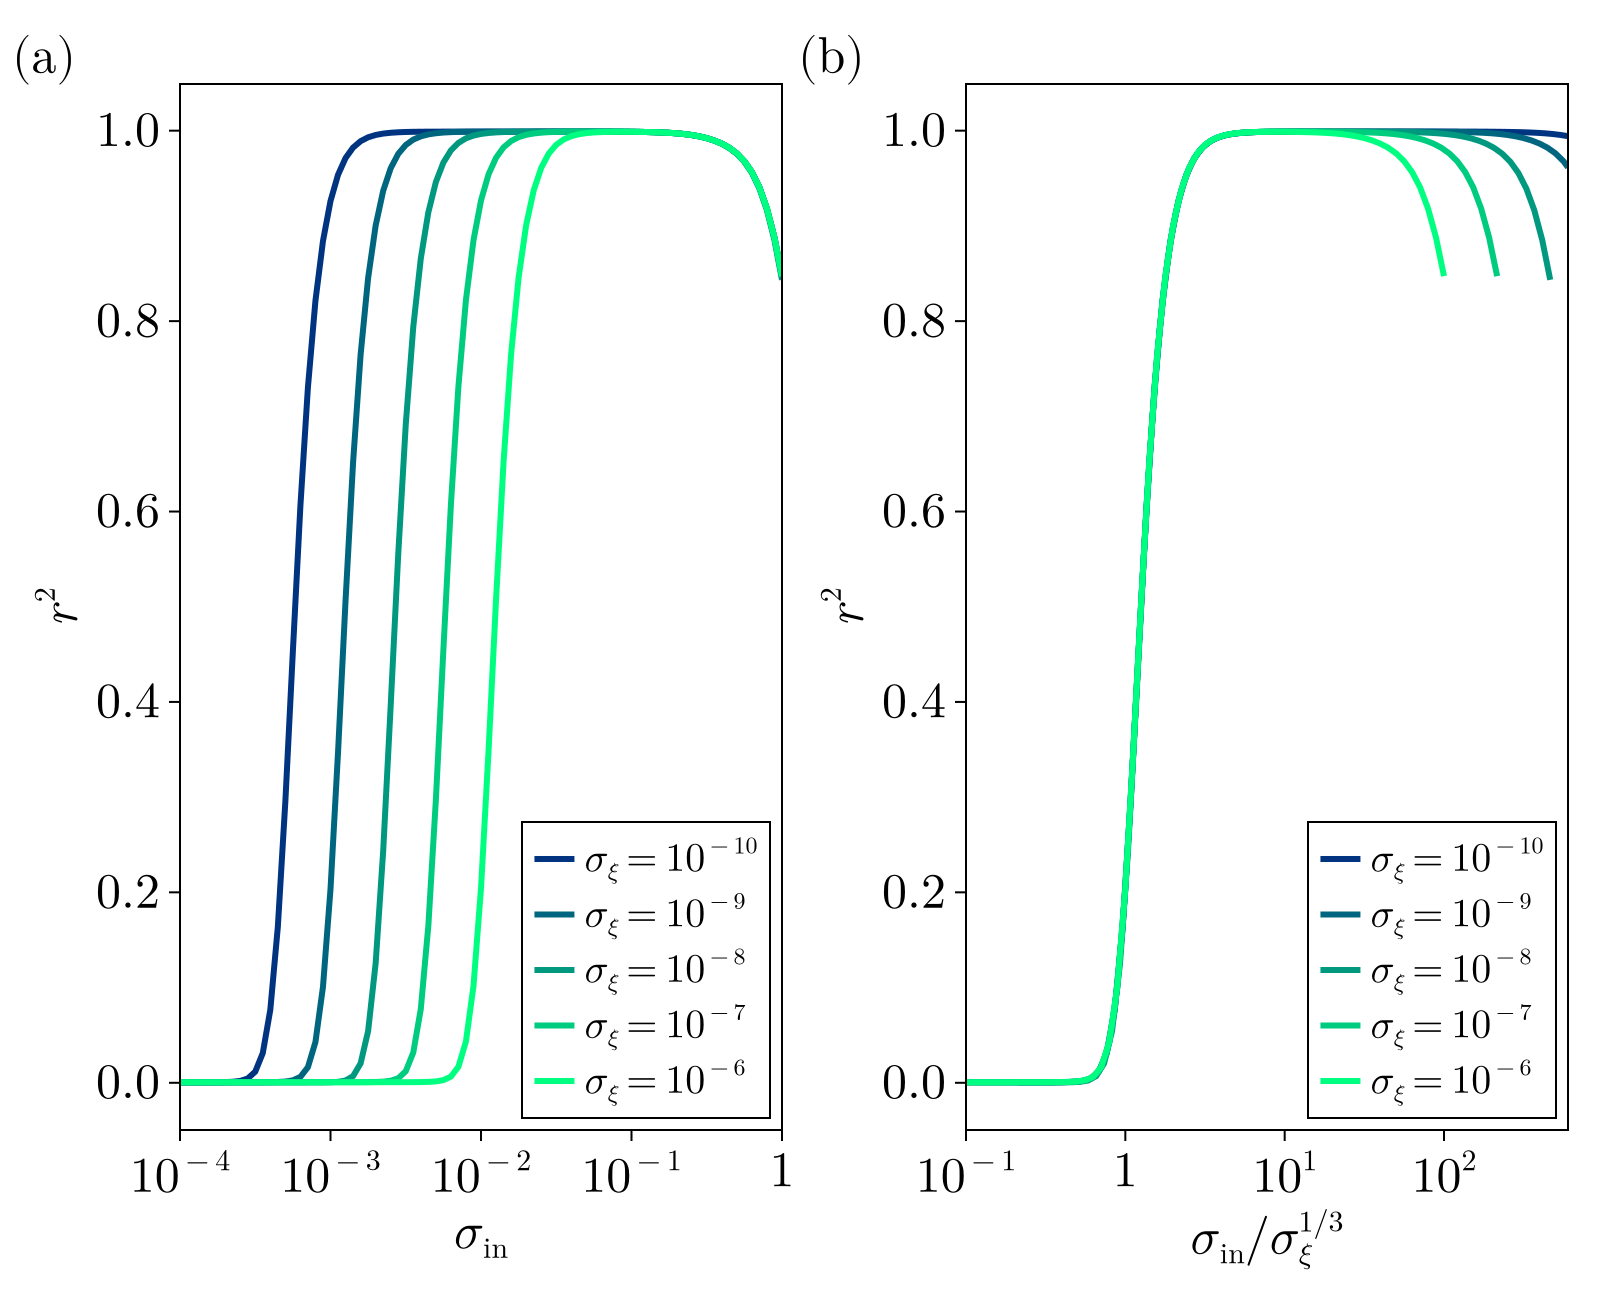

In [6]:
ax = Axis(fig[1, 2];
    xlabel=L"\sigma_{\mathrm{in}} / \sigma_{\xi}^{1/3}",
    ylabel=L"r^2",
    xscale=log10,
    xticks=([1e-1, 1, 1e1, 1e2], [L"10^{-1}", L"1", L"10^{1}", L"10^{2}"]),
    yticks=(0.0:0.2:1.0, [L"0.0", L"0.2", L"0.4", L"0.6", L"0.8", L"1.0"]))

lines!(ax, input_std_grid * (1e-10 ^ (-1/3)), r2_av_list[1], label=L"\sigma_{\xi} = 10^{-10}", linewidth=3, color=RGBf(0, 0.2, 0.5))
lines!(ax, input_std_grid * (1e-9 ^ (-1/3)), r2_av_list[2], label=L"\sigma_{\xi} = 10^{-9}", linewidth=3, color=RGBf(0, 0.4, 0.5))
lines!(ax, input_std_grid * (1e-8 ^ (-1/3)), r2_av_list[3], label=L"\sigma_{\xi} = 10^{-8}", linewidth=3, color=RGBf(0, 0.6, 0.5))
lines!(ax, input_std_grid * (1e-7 ^ (-1/3)), r2_av_list[4], label=L"\sigma_{\xi} = 10^{-7}", linewidth=3, color=RGBf(0, 0.8, 0.5))
lines!(ax, input_std_grid * (1e-6 ^ (-1/3)), r2_av_list[5], label=L"\sigma_{\xi} = 10^{-6}", linewidth=3, color=RGBf(0, 1, 0.5))

xlims!(ax, 1e-1, 6e2)

axislegend(ax; position=:rb)

Label(fig[1, 2, TopLeft()], L"\mathrm{(b)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

fig

In [7]:
# Fitting with a sigmoid function f(x)=a/(1+exp(-b*(x-c))) within a range [x_start, x_end]
function fit_sigmoid(x::Vector{Float64}, y::Vector{Float64}, x_start, x_end)
    indices = findall(x .>= x_start .&& x .<= x_end)
    x_fit = x[indices]
    y_fit = y[indices]

    model(x, p) = p[1] ./ (1 .+ exp.(-p[2] .* (x .- p[3])))

    p0 = [maximum(y_fit), 1.0, mean(x_fit)]

    fit = curve_fit(model, x_fit, y_fit, p0)
    p = fit.param
    return p[1], p[2], p[3]
end

# Fitting with a linear function f(x)=ax+b within a range [x_start, x_end]
function fit_linear(x::Vector{Float64}, y::Vector{Float64}, x_start, x_end)
    indices = findall(x .>= x_start .&& x .<= x_end)
    x_fit = x[indices]
    y_fit = y[indices]

    df = DataFrame(x=x_fit, y=y_fit)

    result = lm(@formula(y ~ x), df)

    intercept, slope = coef(result)
    intercept_error, slope_error = stderror(result)

    return slope, slope_error, intercept, intercept_error
end

fit_linear (generic function with 1 method)

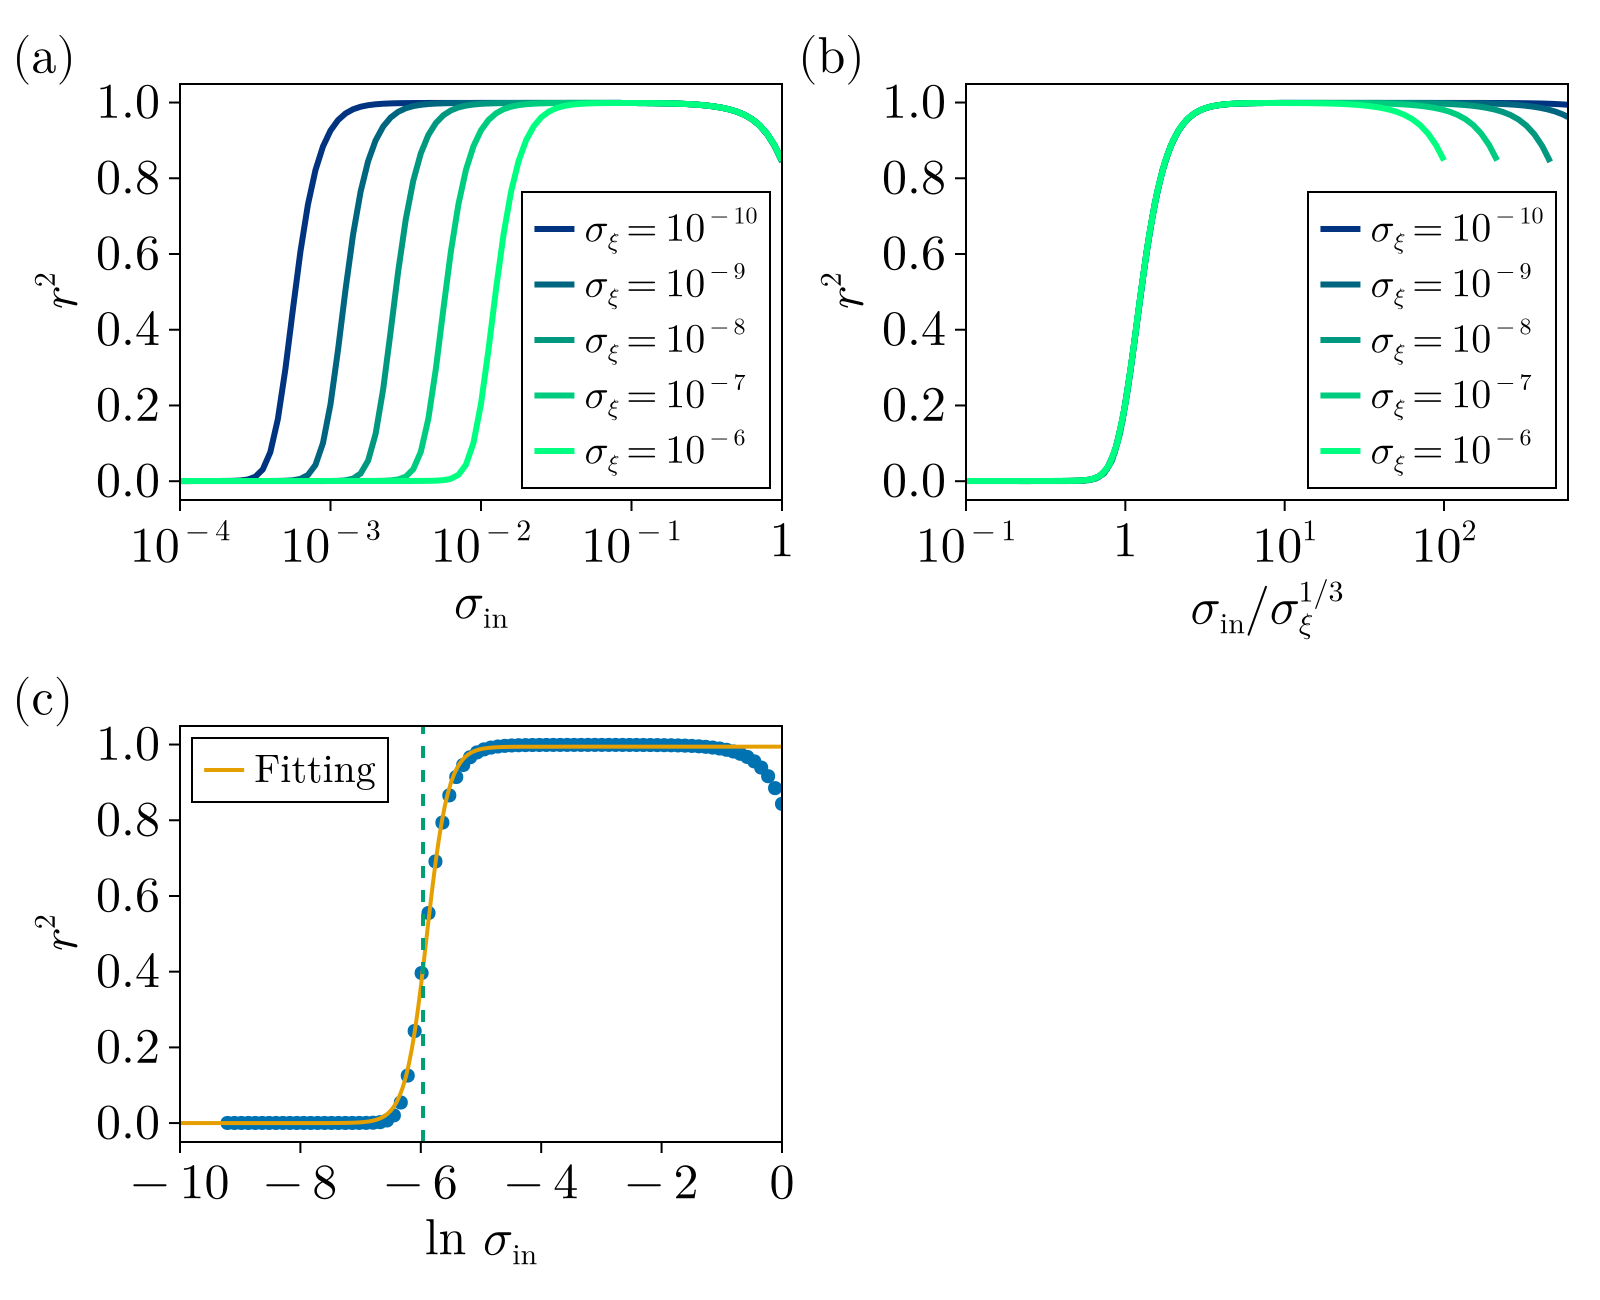

In [8]:
# --- Fitting test ---

r2_av = r2_av_list[3]
log_input_std_grid = log.(input_std_grid)

x_start = minimum(log_input_std_grid)
x_end = log_input_std_grid[argmax(r2_av)]

a, b, c = fit_sigmoid(log_input_std_grid, r2_av, x_start, x_end)
input_std_0 = exp(c) * ((b-1) / (b+1)) ^ (1 / b)

f_fit(x) = a / (1 + exp(-b*(x-c)))
xs = -10.0:0.05:0.0
ys = f_fit.(xs)

ax = Axis(fig[2, 1];
    xlabel=L"\ln \ \sigma_{\mathrm{in}}",
    ylabel=L"r^2",
    xticks=(-10:2:0, [L"-10", L"-8", L"-6", L"-4", L"-2", L"0"]),
    yticks=(0.0:0.2:1.0, [L"0.0", L"0.2", L"0.4", L"0.6", L"0.8", L"1.0"]))

scatter!(ax, log_input_std_grid, r2_av, markersize=10)
lines!(ax, xs, ys, color=Cycled(2), linewidth=2, label=L"\mathrm{Fitting}")
vlines!(ax, [log(input_std_0)], linestyle=:dash, color=Cycled(3), linewidth=2)

xlims!(ax, -10, 0)

axislegend(ax; position=:lt)

Label(fig[2, 1, TopLeft()], L"\mathrm{(c)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

fig

In [9]:
# --- Compute sigma0 for each rho and noise
lognoise_std_list = -9.0:0.5:-5.0
rho_list = [0.4, 0.6, 0.8]

sigma0_list = zeros(length(lognoise_std_list), length(rho_list))

for i in eachindex(lognoise_std_list)
    for j in eachindex(rho_list)
        filename = "data//sigma0_noise_scaling//r2_N=1000_rho=$(rho_list[j])_lognoise=$(lognoise_std_list[i])"
        r2_av = load_average(filename, 5)[:, 1]

        x_start = minimum(log_input_std_grid)
        x_end = log_input_std_grid[argmax(r2_av)]

        a, b, c = fit_sigmoid(log_input_std_grid, r2_av, x_start, x_end)
        sigma0_list[i, j] = exp(c) * ((b-1) / (b+1)) ^ (1 / b)
    end
end

exponent (rho = 0.4): 0.34029457264207297
exponent (rho = 0.6): 0.334128697265761
exponent (rho = 0.8): 0.33316225606666855


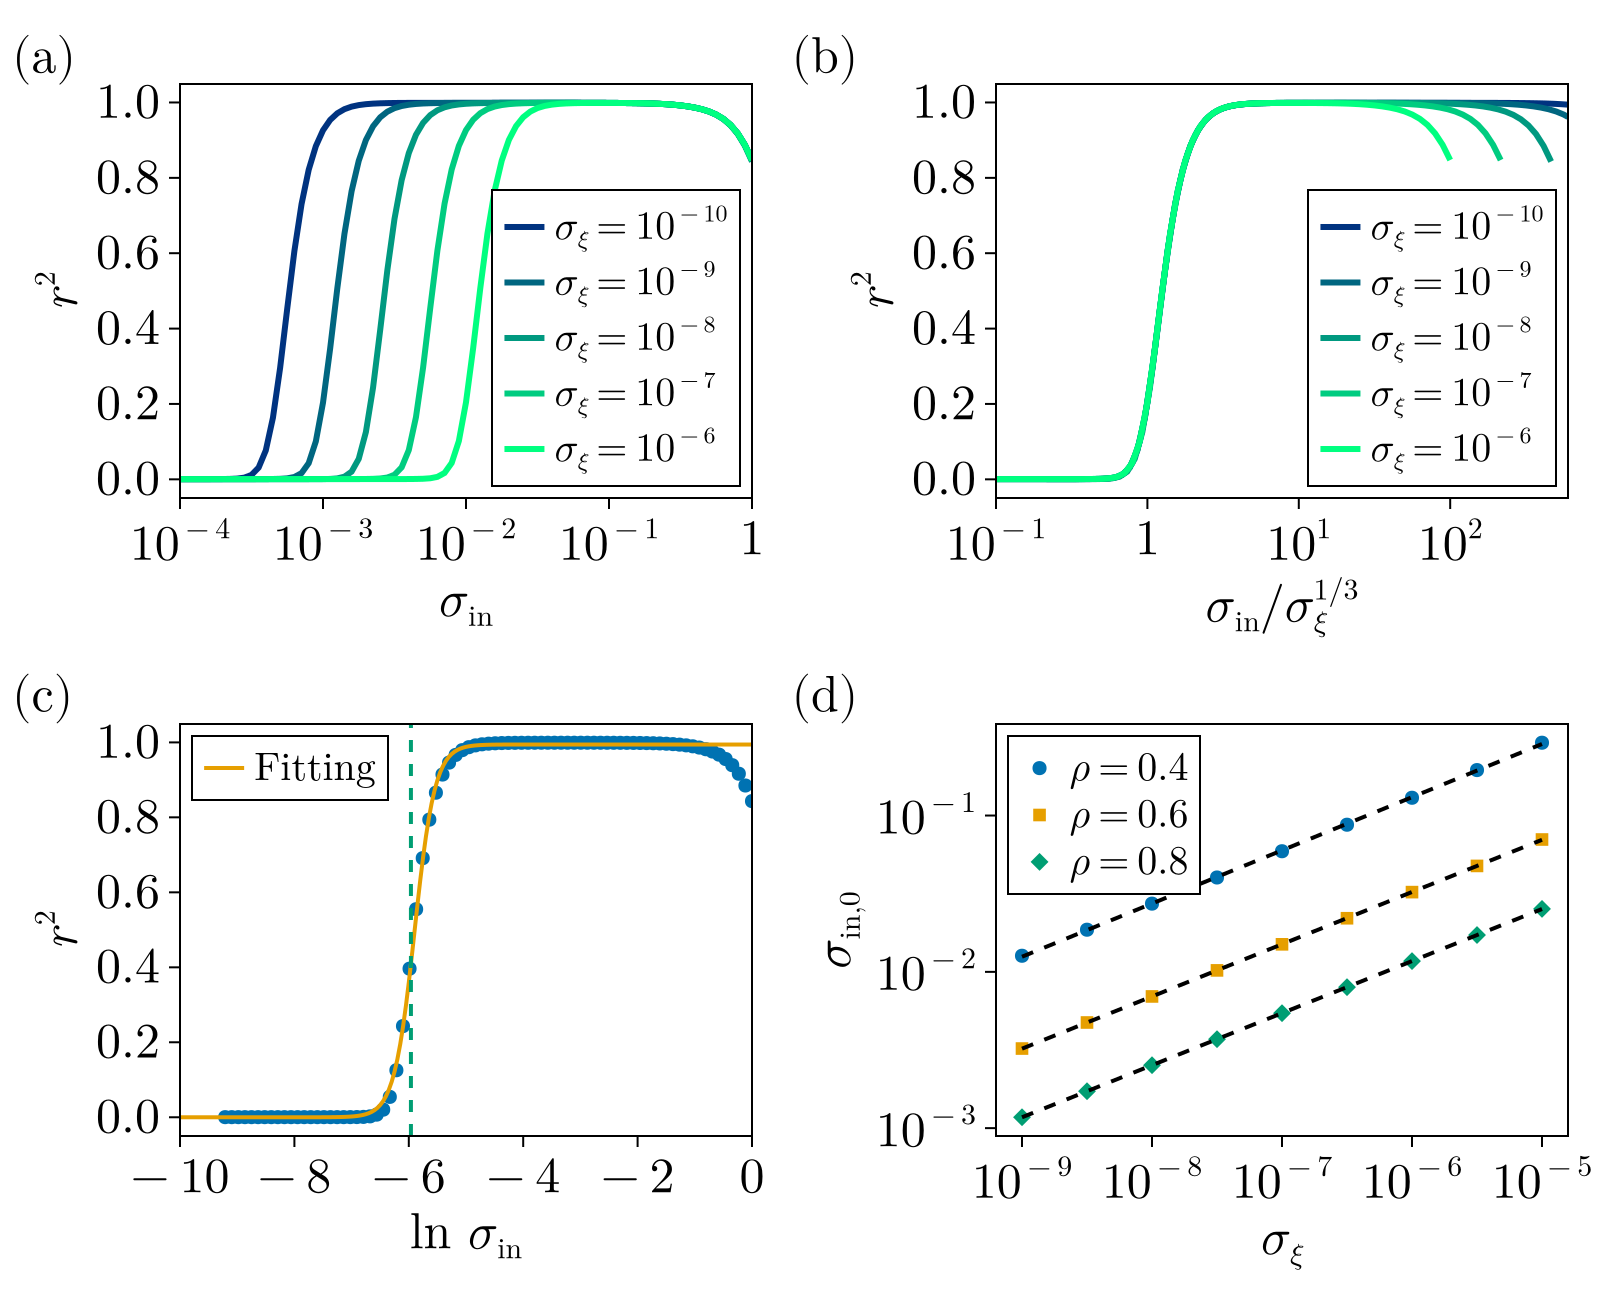

In [10]:
ax = Axis(fig[2, 2];
    xlabel=L"\sigma_{\xi}",
    ylabel=L"\sigma_{\mathrm{in}, 0}",
    xscale=log10,
    yscale=log10,
    xticks=([1e-9, 1e-8, 1e-7, 1e-6, 1e-5], [L"10^{-9}", L"10^{-8}", L"10^{-7}", L"10^{-6}", L"10^{-5}"]),
    yticks=([1e-3, 1e-2, 1e-1], [L"10^{-3}", L"10^{-2}", L"10^{-1}"]))

scatter!(ax, 10 .^ lognoise_std_list, sigma0_list[:, 1], 
    label=L"\rho = 0.4", markersize=10, marker=:circle)
scatter!(ax, 10 .^ lognoise_std_list, sigma0_list[:, 2], 
    label=L"\rho = 0.6", markersize=10, marker=:rect)
scatter!(ax, 10 .^ lognoise_std_list, sigma0_list[:, 3], 
    label=L"\rho = 0.8", markersize=10, marker=:diamond)

slope1, slope_error1, intercept1, intercept_error1 = fit_linear(collect(lognoise_std_list), log10.(sigma0_list[:, 1]), -10.0, -4.0)
slope2, slope_error2, intercept2, intercept_error2 = fit_linear(collect(lognoise_std_list), log10.(sigma0_list[:, 2]), -10.0, -4.0)
slope3, slope_error3, intercept3, intercept_error3 = fit_linear(collect(lognoise_std_list), log10.(sigma0_list[:, 3]), -10.0, -4.0)

println("exponent (rho = 0.4): ", slope1)
println("exponent (rho = 0.6): ", slope2)
println("exponent (rho = 0.8): ", slope3)

xs = 10 .^ (-9.0:0.1:-5.0)
ys_1 = 10^intercept1 * xs .^ slope1
ys_2 = 10^intercept2 * xs .^ slope2
ys_3 = 10^intercept3 * xs .^ slope3
lines!(ax, xs, ys_1, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_2, color=:black, linestyle=:dash, linewidth=2)
lines!(ax, xs, ys_3, color=:black, linestyle=:dash, linewidth=2)

axislegend(ax; position=:lt)

Label(fig[2, 2, TopLeft()], L"\mathrm{(d)}";
    fontsize=25,
    halign=:left,
    padding  = (-10, 0, 0, 0))

colgap!(fig.layout, 1, Relative(0.05))

fig

In [11]:
save("fig3_noise_scaling.pdf", fig)

CairoMakie.Screen{PDF}
